In [16]:
from train_two_p import ExperimentParamsTwoP, evaluate_model_logits
import torch as t
from tqdm import tqdm
import random
from helpers import get_submodule_param_mask
from math import log, sqrt
from two_p_model import TwoPMLP
from two_p_dataset import make_two_p_dataset, make_two_p_dataset_with_exceptions, train_test_split
from matplotlib import pyplot as plt
from datetime import datetime
from collections import defaultdict
from dataclasses import dataclass
from typing import Callable, Optional
import json
from glob import glob
from model_viz import viz_weights_modes
from movie import run_movie_cmd
import os
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from dynamics import get_magnitude_modes


@dataclass
class SGLDParams:
    gamma: float = 1
    epsilon: float = 0.001
    n_steps: int = 10000
    m: int = 512  # SGLD batch size
    restrict_to_orth_grad: bool = False
    get_updated_model_parameters: Callable = lambda model: model.parameters()  # Override to only search parameter subspace
    n_multiplier: float = 1
    movie: bool = False
    num_point_samples: Optional[int] = None
    n_magnitude_samples: Optional[int] = None
    weight_decay: float = 0
    logit_scaling: float = 1.0
    temp_multiplier: float = 1.0


def cross_entropy_loss(logits, y_s, logit_scaling=1):
    """
    logits: outputs of model
    y: target labels

    returns: mean cross entropy loss
    """
    preds = t.nn.functional.softmax(logits * logit_scaling, dim=1)
    return -1 * t.mean(t.log(preds[t.arange(len(preds)), y_s] + 1e-7))


def get_full_train_loss(model, dataset, device, logit_scaling=1):
    model = model.to(device)
    X1 = t.stack([sample[0] for sample in dataset]).to(device)
    X2 = t.stack([sample[1] for sample in dataset]).to(device)
    X3 = t.stack([sample[2] for sample in dataset]).to(device)
    X4 = t.stack([sample[3] for sample in dataset]).to(device)
    Y1 = t.stack([sample[4] for sample in dataset]).to(device)
    Y2 = t.stack([sample[5] for sample in dataset]).to(device)

    
    seeds = t.rand(Y1.size(0), device=device)
    mask = seeds < 0.5
    labels = Y1.clone()
    labels[~mask] = Y2[~mask]
    
    out = model(X1, X2, X3, X4)
    loss = cross_entropy_loss(out, labels, logit_scaling=logit_scaling)
    return loss


def mean(arr):
    return sum(arr) / len(arr)


def sgld(model, sgld_params, dataset, device):
    """
    model: MLP model
    sgld_params: SGLDParams object
    dataset: dataset to train on
    device: device to run on

    returns: updated model, lambda_hat
    """
    n = len(dataset)
    model = model.to(device)
    effective_n = n * sgld_params.n_multiplier

    inverse_temp = effective_n / log(effective_n)
    inverse_temp /= sgld_params.temp_multiplier

    init_loss = get_full_train_loss(
        model, dataset, device, logit_scaling=sgld_params.logit_scaling
    )

    idx = list(range(len(dataset)))
    optimizer = t.optim.SGD(
        sgld_params.get_updated_model_parameters(model),
        weight_decay=0,
        lr=1,
    )

    submodule_param_mask = get_submodule_param_mask(
        model, sgld_params.get_updated_model_parameters
    ).to(device)

    w_0 = (
        t.nn.utils.parameters_to_vector(model.parameters()).detach().clone().to(device)
    )

    cross_entropy_loss_value = get_full_train_loss(
        model, dataset, device, logit_scaling=sgld_params.logit_scaling
    )

    # Compute gradients using torch.autograd.grad
    gradients = t.autograd.grad(
        cross_entropy_loss_value, model.parameters(), create_graph=True
    )
    ce_loss_grad_w0 = (
        t.nn.utils.parameters_to_vector(gradients).detach().clone().to(device)
    )
    ce_loss_grad_w0 *= submodule_param_mask
    ce_loss_grad_w0 /= ce_loss_grad_w0.norm(p=2)
    optimizer.zero_grad()

    array_loss = []
    array_weight_norm = []
    magnitude_modes = []

    frame_every = sgld_params.n_steps // 50
    sample_every = None
    if sgld_params.num_point_samples is not None:
        sample_every = sgld_params.n_steps // sgld_params.num_point_samples
        # make directory for point samples
        os.makedirs("point_samples", exist_ok=True)
        # empty directory
        files = glob("point_samples/*.json")
        for f in files:
            os.remove(f)
    mag_every = None
    if sgld_params.n_magnitude_samples is not None:
        mag_every = sgld_params.n_steps // sgld_params.n_magnitude_samples
    step = 0
    for sgld_step in tqdm(range(sgld_params.n_steps)):
        batch_idx = random.choices(idx, k=sgld_params.m)
        X1 = t.stack([dataset[b][0] for b in batch_idx]).to(device)
        X2 = t.stack([dataset[b][1] for b in batch_idx]).to(device)
        X3 = t.stack([dataset[b][2] for b in batch_idx]).to(device)
        X4 = t.stack([dataset[b][3] for b in batch_idx]).to(device)
        Y1 = t.stack([dataset[b][4] for b in batch_idx]).to(device)
        Y2 = t.stack([dataset[b][5] for b in batch_idx]).to(device)
        
        seeds = t.rand(Y1.size(0), device=device)
        mask = seeds < 0.5
        labels = Y1.clone()
        labels[~mask] = Y2[~mask]
    
        optimizer.zero_grad()
        out = model(X1, X2, X3, X4)
        cross_entropy_loss_value = cross_entropy_loss(
            out, labels, logit_scaling=sgld_params.logit_scaling
        )
        
        array_loss.append(cross_entropy_loss_value.item())
        w = t.nn.utils.parameters_to_vector(model.parameters())
        array_weight_norm.append((w * submodule_param_mask).norm(p=2).item())
        elasticity_loss_term = (sgld_params.gamma / 2) * t.sum(((w_0 - w) ** 2))
        weight_size_term = t.sum(w**2) * (sgld_params.weight_decay / 2)
        log_likelihood_loss_term = (
            cross_entropy_loss_value + weight_size_term
        ) * inverse_temp
        full_loss = (sgld_params.epsilon / 2) * (
            elasticity_loss_term + log_likelihood_loss_term
        )
        full_loss.backward()
        optimizer.step()
        eta = (
            t.randn_like(w, device=device)
            * sqrt(sgld_params.epsilon)
            * submodule_param_mask
        )
        with t.no_grad():
            new_params = t.nn.utils.parameters_to_vector(model.parameters()) + eta
            if sgld_params.restrict_to_orth_grad:
                diff = new_params - w_0
                proj_diff = diff - t.dot(diff, ce_loss_grad_w0) * ce_loss_grad_w0
                new_params = w_0 + proj_diff
            t.nn.utils.vector_to_parameters(new_params, model.parameters())

        if sgld_step % frame_every == 0 and sgld_params.movie:
            viz_weights_modes(
                model.embedding.weight.detach().cpu(),
                out.shape[-1],
                f"frames/embeddings_movie_{step:06}.png",
            )
            step += 1

        if sample_every is not None:
            if sgld_step % sample_every == 0:
                with t.no_grad():
                    full_loss_value = get_full_train_loss(
                        model, dataset, device, logit_scaling=sgld_params.logit_scaling
                    ).item()
                    data = {
                        "full_loss": float(full_loss_value),
                        "new_params": list(
                            [float(x) for x in new_params.cpu().numpy().flatten()]
                        ),
                    }
                    with open(
                        f"point_samples/point_sample_{sgld_step:06}.json", "w"
                    ) as f:
                        json.dump(data, f)
        if mag_every is not None:
            if sgld_step % mag_every == 0:
                with t.no_grad():
                    p = model.embedding.weight.shape[0]
                    modes = get_magnitude_modes(
                        model.embedding.weight.detach().cpu(), p
                    )
                    modes = modes.tolist()
                    modes = modes[1 : p // 2 + 1]
                    magnitude_modes.append(modes)

    lambda_hat = (mean(array_loss[len(array_loss) // 4 :]) - init_loss) * inverse_temp

    print(f"lambda_hat: {lambda_hat}")
    # print(f"init_loss: {init_loss}")
    # print(f"sgld_params: {sgld_params}")
    # print(f"array_loss: {array_loss[::len(array_loss)//20]}")
    # print(f"array_weight_norm: {array_weight_norm[::len(array_weight_norm)//20]}")
    
    if sgld_params.movie:
        run_movie_cmd("sgld")
    if sgld_params.num_point_samples is not None:
        point_sample_pca(colormapping_loss=True)
    if len(magnitude_modes) > 0:
        # Get indices of largest 2 modes at init
        init_modes = magnitude_modes[0]
        init_modes = sorted(
            range(len(init_modes)), key=lambda i: init_modes[i], reverse=True
        )
        mode_1 = init_modes[0]
        mode_2 = init_modes[1]
        # Get the values of mode_1 and mode_2 at each step
        mode_1_values = [m[mode_1] for m in magnitude_modes]
        mode_2_values = [m[mode_2] for m in magnitude_modes]
        # Plot
        plt.clf()
        fig, ax = plt.subplots()
        cmap = plt.cm.get_cmap("rainbow")
        norm = plt.Normalize(vmin=0, vmax=len(mode_1_values))
        colors = [cmap(norm(i)) for i in range(len(mode_1_values))]
        ax.scatter(mode_1_values, mode_2_values, marker="o", s=10, c=colors)
        ax.set_xlabel(f"Mode {mode_1+1}")
        ax.set_ylabel(f"Mode {mode_2+1}")
        fig.savefig(
            f'plots/magnitude_modes_SGLD_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
        )
        plt.clf()
        fig, ax = plt.subplots()
        for i, m in enumerate(magnitude_modes):
            ax.plot(
                m[: p // 2 + 1],
                label=f"Step {mag_every*i}",
                marker="o",
                c=colors[i],
                markersize=6,
            )
        ax.set_xlabel("Mode")
        ax.set_ylabel("Magnitude")
        ax.legend()
        # title
        plt.title("Fourier mode magnitude vs. SGLD sampling checkpoint")
        fig.savefig(
            f'plots/magnitude_modes_SGLD_all_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
        )
    return model, lambda_hat


def point_sample_pca(colormapping_loss=True):
    # get point samples from /point_samples and plot pca in weight space with color corresponding to full loss (use rainbow colormap)
    files = glob("point_samples/*.json")
    # sort filenames by sgld step
    files = sorted(files, key=lambda x: int(x.split("_")[-1].split(".")[0]))
    points = []
    losses = []
    for f in files:
        with open(f, "r") as f:
            data = json.load(f)
            points.append(data["new_params"])
            losses.append(data["full_loss"])
    points = t.tensor(points)
    losses = t.tensor(losses)
    # normalize points
    points = (points - points.mean(dim=0)) / points.std(dim=0)
    # fillnan with 0
    points[points != points] = 0

    print("points", points.shape)
    print("losses", losses.shape)
    pca = PCA(n_components=2)
    pca.fit(points)
    points_pca = pca.transform(points)
    print("points_pca", points_pca.shape)
    print("explained variance", pca.explained_variance_ratio_)
    print("singular values", pca.singular_values_)
    print("components", pca.components_)
    print("mean", pca.mean_)
    print("noise variance", pca.noise_variance_)
    print("losses", losses)

    # Plot 200 equally spaced points
    points_pca = points_pca[:: len(points_pca) // 200]
    losses = losses[:: len(losses) // 200]

    # Plot PCA
    plt.clf()
    fig, ax = plt.subplots()

    # Round losses to 2 decimal places
    losses = [float(l) for l in losses]

    # map color to loss
    if colormapping_loss:
        cmap = plt.cm.get_cmap("rainbow")
        norm = plt.Normalize(vmin=min(losses), vmax=max(losses))
        colors = [cmap(norm(l)) for l in losses]
    else:
        cmap = plt.cm.get_cmap("rainbow")
        norm = plt.Normalize(vmin=0, vmax=len(losses))
        colors = [cmap(norm(i)) for i in range(len(losses))]

    # Plot points with small marker size
    ax.scatter(points_pca[:, 0], points_pca[:, 1], c=colors, s=6)

    # Label points with loss values
    # for i, txt in enumerate([f"{i}, {round(l, 2)}" for i, l in enumerate(losses)]):
    #     ax.annotate(txt, (points_pca[i][0], points_pca[i][1]), fontsize=7)

    # Set x and y labels
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    fig.savefig(
        f'plots/point_samples_pca_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
    )


def get_lambda(params, sgld_params, checkpoint_no=None):
    model = TwoPMLP(params)
    print(f"models/model_{params.get_suffix()}.pt")
    try:
        path = "models/model_P1=7_P2=11.pt"
        # f"models/model_{params.get_suffix()}.pt"
        model.load_state_dict(t.load(path))
    except Exception as e:
        print(f"Failed to load model state: {e}")
        raise
    
    dataset = None
    if params.use_exceptions: 
        print("using exceptions")
        dataset, _ = make_two_p_dataset_with_exceptions(params)
    else: 
        dataset = make_two_p_dataset(params)

    train_data, test_data = train_test_split(
        dataset
    )

    model = model.to('mps')
    loss_p1, loss_p2, acc_p1, acc_p2, k1, k2 = evaluate_model_logits(model, train_data, params)
    print(f"""
                      TRAIN SET:
                      loss_p1: {loss_p1}, loss_p2: {loss_p2}, 
                      acc_p1: {acc_p1}, acc_p2: {acc_p2}
                      loss exceps: {k1}, acc_exceps: {k2}
                      """)
    loss_p1, loss_p2, acc_p1, acc_p2, k1, k2 = evaluate_model_logits(model, test_data, params)
    print(f"""
                      TEST SET:
                      loss_p1: {loss_p1}, loss_p2: {loss_p2}, 
                      acc_p1: {acc_p1}, acc_p2: {acc_p2}
                      loss exceps: {k1}, acc_exceps: {k2}
                      """)
    
    test_loss = get_full_train_loss(model, test_data, params.device)
    train_loss = get_full_train_loss(model, train_data, params.device)

    print("initial test loss", test_loss)
    print("initial train loss", train_loss)

    _, lambda_hat = sgld(model, sgld_params, test_data, params.device)
    lambda_hat, test_loss, train_loss = lambda_hat.cpu().item(), test_loss.cpu().item(), train_loss.cpu().item()
    return lambda_hat, test_loss, train_loss


def plot_lambda_test_train_loss(
    ax1, x_axis, x_label, lambda_values, test_losses, train_losses
):
    # Plot lambda values on the left y-axis
    ax1.plot(x_axis, lambda_values, marker="o", label="$\hat{\lambda}$", color="g")
    # ax1.plot(x_axis, [8 * x for x in x_axis], label="y=8x", linestyle="--")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel("$\hat{\lambda}$")
    ax1.tick_params("y", colors="g")
    ax1.legend(loc="upper left")

    # Create a second y-axis for the losses
    ax2 = ax1.twinx()
    ax2.plot(
        x_axis, train_losses, marker="o", color="b", label="train loss", linestyle="--"
    )
    ax2.plot(
        x_axis, test_losses, marker="o", color="r", label="test loss", linestyle="--"
    )
    ax2.set_ylabel("Loss", color="b")
    ax2.tick_params("y", colors="b")
    ax2.legend(loc="lower right")

if __name__ == "__main__":
    import csv
    import plotly.express as px
    import pandas as pd
    import sympy

    sgld_params = SGLDParams(
        gamma=5,
        epsilon=0.0001,
        n_steps=200,
        m=64,
        restrict_to_orth_grad=True,
        weight_decay=0.0
    )
    # # primes_under_100 = sympy.primerange(1, 100)
    # llc_results = []
    # # print(list(primes_under_100))

    # # for p1 in sympy.primerange(1, 100):
    # #     for p2 in sympy.primerange(1, 100):
    # p1 = 13
    # p2 = 11
    # n_rands = 20
    
    # param_file = f"exp_params/two_p_modadd_exceptions/p1={p1}_p2={p2}_nrands={n_rands}.json"
    # print(param_file)
    # params = ExperimentParamsTwoP.load_from_file(param_file)
    # check_list = list(range(params.n_save_model_checkpoints))
    # lambda_hat, test_loss, train_loss = get_lambda(params, sgld_params, check_list[-1])
    
    # p1 = 13
    # p2 = 11
    # n_rands = 0
    
    # param_file = f"exp_params/two_p_modadd_exceptions/p1={p1}_p2={p2}_nrands={n_rands}.json"
    # print(param_file)
    # params = ExperimentParamsTwoP.load_from_file(param_file)
    # check_list = list(range(params.n_save_model_checkpoints))
    # lambda_hat, test_loss, train_loss = get_lambda(params, sgld_params, check_list[-1])
    # # llc_results.append({'p1': p1, 'p2': p2, 'LLC': lambda_hat})
    

In [19]:
import pandas as pd

df = pd.read_csv("exp_params/two_p_modadd_exceptions_two/final_losses.csv")

llc_results = []

for index, row in df.iterrows():
    params = ExperimentParamsTwoP.load_from_file(row['params_filename'])
    
    lambda_hat, test_loss, train_loss = get_lambda(params, sgld_params, params.n_save_model_checkpoints - 1)
    
    llc_results.append({
        'p1': params.p1,
        'p2': params.p2,
        'n_rands': params.n_rands,
        'LLC': lambda_hat
    })

llc_df = pd.DataFrame(llc_results)

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
for (p1, p2), group in llc_df.groupby(['p1', 'p2']):
    plt.scatter(group['n_rands'], group['LLC'], label=f'p1={p1}, p2={p2}', marker='o')

plt.title('LLC vs n_rands for each p1, p2 pair')
plt.xlabel('n_rands')
plt.ylabel('LLC')
plt.legend()
plt.grid(True)
plt.show()

models/model_P1=7_P2=11.pt
Example entry: (0, 0) (0, 0) labels: 0 7
Dataset size: 5929


/var/folders/rb/qfsrq8wj53d1n4vbrb800gx40000gq/T/ipykernel_26662/3409258704.py:356: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(path))


/var/folders/rb/qfsrq8wj53d1n4vbrb800gx40000gq/T/ipykernel_3245/4284142149.py:16: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



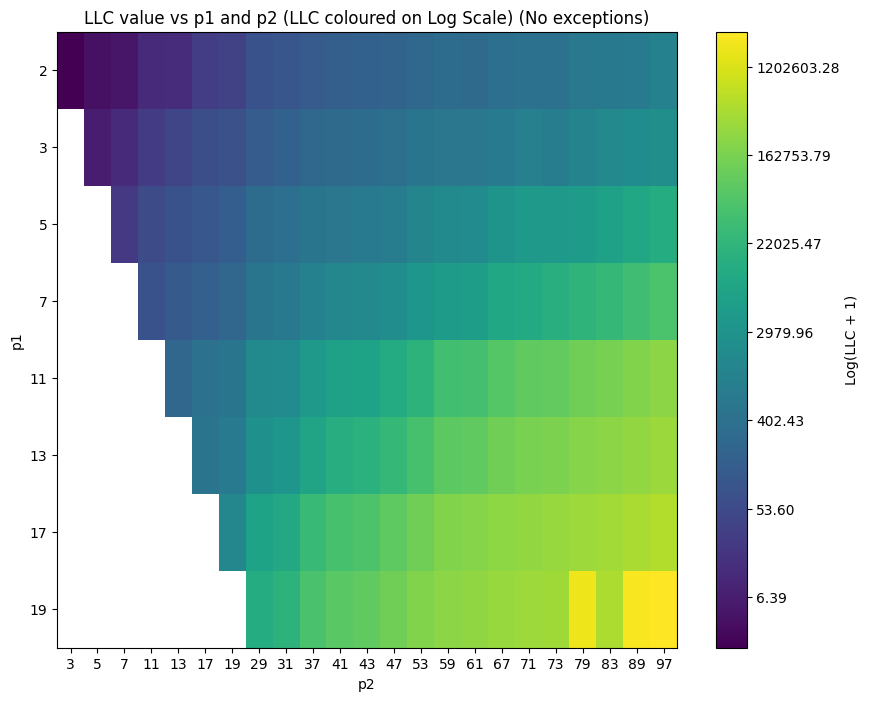

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('llc_results.csv')

# Filter out rows where p1 or p2 is 23
df_filtered = df[(df['p1'] != 23) & (df['p2'] != 23)]

pivot_table = df_filtered.pivot(index='p1', columns='p2', values='LLC')

plt.figure(figsize=(10, 8))
# Use a logarithmic scale for the color mapping
plt.imshow(np.log1p(pivot_table), cmap='viridis', aspect='auto')
cbar = plt.colorbar(label='Log(LLC + 1)')
cbar.ax.set_yticklabels([f'{np.exp(tick) - 1:.2f}' for tick in cbar.get_ticks()])
plt.title('LLC value vs p1 and p2 (LLC coloured on Log Scale) (No exceptions)')
plt.xlabel('p2')
plt.ylabel('p1')
plt.xticks(ticks=range(len(pivot_table.columns)), labels=pivot_table.columns)
plt.yticks(ticks=range(len(pivot_table.index)), labels=pivot_table.index)
plt.show()


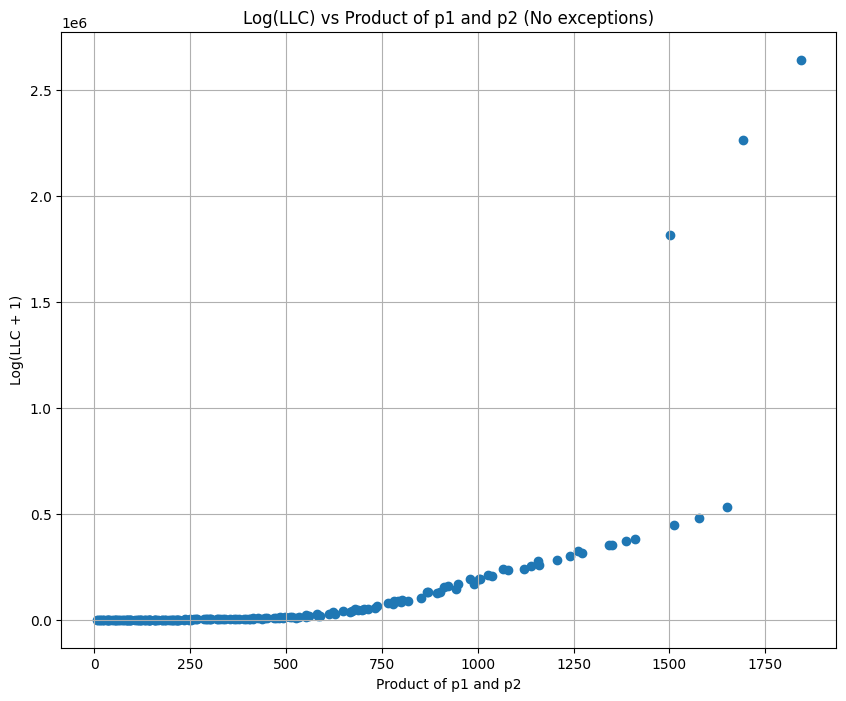

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('llc_results.csv')

# Calculate the product of p1 and p2
df['product'] = df['p1'] * df['p2']

plt.figure(figsize=(10, 8))
# Use a logarithmic scale for the LLC values
plt.scatter(df['product'], df['LLC'], marker='o')
plt.title('Log(LLC) vs Product of p1 and p2 (No exceptions)')
plt.xlabel('Product of p1 and p2')
plt.ylabel('Log(LLC + 1)')
plt.grid(True)
plt.show()
